# Clustering PGCLCs

### Resources
* Tutorial scanpy https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html
* Tutorial scvi https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/harmonization.html

In [3]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch

In [5]:
print(sc.__version__)
print(torch.__version__)
print(pd.__version__)
print(scvi.__version__)
print(scvi)
print(torch.cuda.is_available())

1.9.8
2.2.1
2.2.1
1.1.2
<module 'scvi' from '/data1/imoustakas/miniforge3/envs/scvi/lib/python3.9/site-packages/scvi/__init__.py'>
True


In [6]:
! echo $CUDA_VISIBLE_DEVICES

0


/data1/imoustakas/miniforge3/envs/scvi/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [7]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.8 anndata==0.10.6 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11


## Load h5ad, output of Seura tworkflow

In [8]:
# CR27_d15PGCLC = sc.read_10x_mtx("/exports/sasc/project-477-PGCLC_10x_yolanda/analysis/STARsolo_pipe/CR27_d15PGCLC/CR27_d15PGCLCSolo.out/Gene/filtered/")
# CR27_d5PGCLC = sc.read_10x_mtx("/exports/sasc/project-477-PGCLC_10x_yolanda/analysis/STARsolo_pipe/CR27_d5PGCLC/CR27_d5PGCLCSolo.out/Gene/filtered/")
# MB12_d5PGCLC = sc.read_10x_mtx("/exports/sasc/project-477-PGCLC_10x_yolanda/analysis/STARsolo_pipe/MB12_d5PGCLC/MB12_d5PGCLCSolo.out/Gene/filtered/")
# YD90_d15PGCLC = sc.read_10x_mtx("/exports/sasc/project-477-PGCLC_10x_yolanda/analysis/STARsolo_pipe/YD90_d15PGCLC/YD90_d15PGCLCSolo.out/Gene/filtered/")

In [9]:
CR27_d15PGCLC = sc.read_10x_mtx("/data1/imoustakas/project-477-PGCLC_10x_yolanda/PGCLC_counts/CR27_d15PGCLC/")
CR27_d5PGCLC = sc.read_10x_mtx("/data1/imoustakas/project-477-PGCLC_10x_yolanda/PGCLC_counts/CR27_d5PGCLC/")
MB12_d5PGCLC = sc.read_10x_mtx("/data1/imoustakas/project-477-PGCLC_10x_yolanda/PGCLC_counts/MB12_d5PGCLC/")
YD90_d15PGCLC = sc.read_10x_mtx("/data1/imoustakas/project-477-PGCLC_10x_yolanda/PGCLC_counts/YD90_d15PGCLC/")

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [10]:
adata = sc.concat([CR27_d15PGCLC, CR27_d5PGCLC, MB12_d5PGCLC, YD90_d15PGCLC], 
                  label="run",
                  keys=["CR27_d15", "CR27_d5", "MB12_d5", "YD90_d15"],
                  index_unique="_")
# adata.obs_names_make_unique()
adata

AnnData object with n_obs × n_vars = 32537 × 36604
    obs: 'run'

In [11]:
adata.obs["run"]

AAACCCAAGAGCAAGA_CR27_d15    CR27_d15
AAACCCAAGCAGTACG_CR27_d15    CR27_d15
AAACCCAAGGCAGGGA_CR27_d15    CR27_d15
AAACCCACACGGCGTT_CR27_d15    CR27_d15
AAACCCACAGCACAAG_CR27_d15    CR27_d15
                               ...   
TTTGTTGGTTGGATCT_YD90_d15    YD90_d15
TTTGTTGTCACCTCAC_YD90_d15    YD90_d15
TTTGTTGTCATTCATC_YD90_d15    YD90_d15
TTTGTTGTCCACGTAA_YD90_d15    YD90_d15
TTTGTTGTCCCGAGGT_YD90_d15    YD90_d15
Name: run, Length: 32537, dtype: category
Categories (4, object): ['CR27_d15', 'CR27_d5', 'MB12_d5', 'YD90_d15']

## Basic Filtering

In [12]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

filtered out 8047 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 32537 × 28557
    obs: 'run', 'n_genes'
    var: 'n_cells'

## Load the Seurat object and extract the cells IDs
These cells are past filtering (usual QC and doublet removal). We will work with the same cell set

In [13]:
# adata_seurat = sc.read_h5ad("/exports/sasc/project-477-PGCLC_10x_yolanda/analysis/seurat_STAR/PGCLCs.h5ad")
adata_seurat = sc.read_h5ad("/data1/imoustakas/project-477-PGCLC_10x_yolanda/scvi/PGCLCs.h5ad")

/data1/imoustakas/miniforge3/envs/scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [14]:
result = adata_seurat.obs_names.str.split(pat=r'_(?!.*_)')
adata_seurat.obs_names = [l[1] + "_" + l[0] for l in result]
adata_seurat.obs_names

Index(['AAACCCACAAACCGGA_CR27_d5', 'AAACCCACACTTGTGA_CR27_d5',
       'AAACCCACAGTCTTCC_CR27_d5', 'AAACCCAGTCTAATCG_CR27_d5',
       'AAACCCATCATAGGCT_CR27_d5', 'AAACGAACAACCAATC_CR27_d5',
       'AAACGAACAATTCTCT_CR27_d5', 'AAACGAACACCAGTAT_CR27_d5',
       'AAACGAACAGTCTACA_CR27_d5', 'AAACGCTAGTCTCCTC_CR27_d5',
       ...
       'TTTGGTTTCCTGTTAT_YD90_d15', 'TTTGGTTTCTCGCGTT_YD90_d15',
       'TTTGTTGCACAAATGA_YD90_d15', 'TTTGTTGCAGCGGATA_YD90_d15',
       'TTTGTTGCATCTAGAC_YD90_d15', 'TTTGTTGGTTGGATCT_YD90_d15',
       'TTTGTTGTCACCTCAC_YD90_d15', 'TTTGTTGTCATTCATC_YD90_d15',
       'TTTGTTGTCCACGTAA_YD90_d15', 'TTTGTTGTCCCGAGGT_YD90_d15'],
      dtype='object', length=26383)

In [15]:
adata = adata[adata.obs_names.isin(adata_seurat.obs_names), :]

In [16]:
adata

View of AnnData object with n_obs × n_vars = 26383 × 28557
    obs: 'run', 'n_genes'
    var: 'n_cells'

In [17]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

/tmp/ipykernel_21082/2180824350.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"] = adata.var_names.str.startswith("MT-")


## Viollin plots

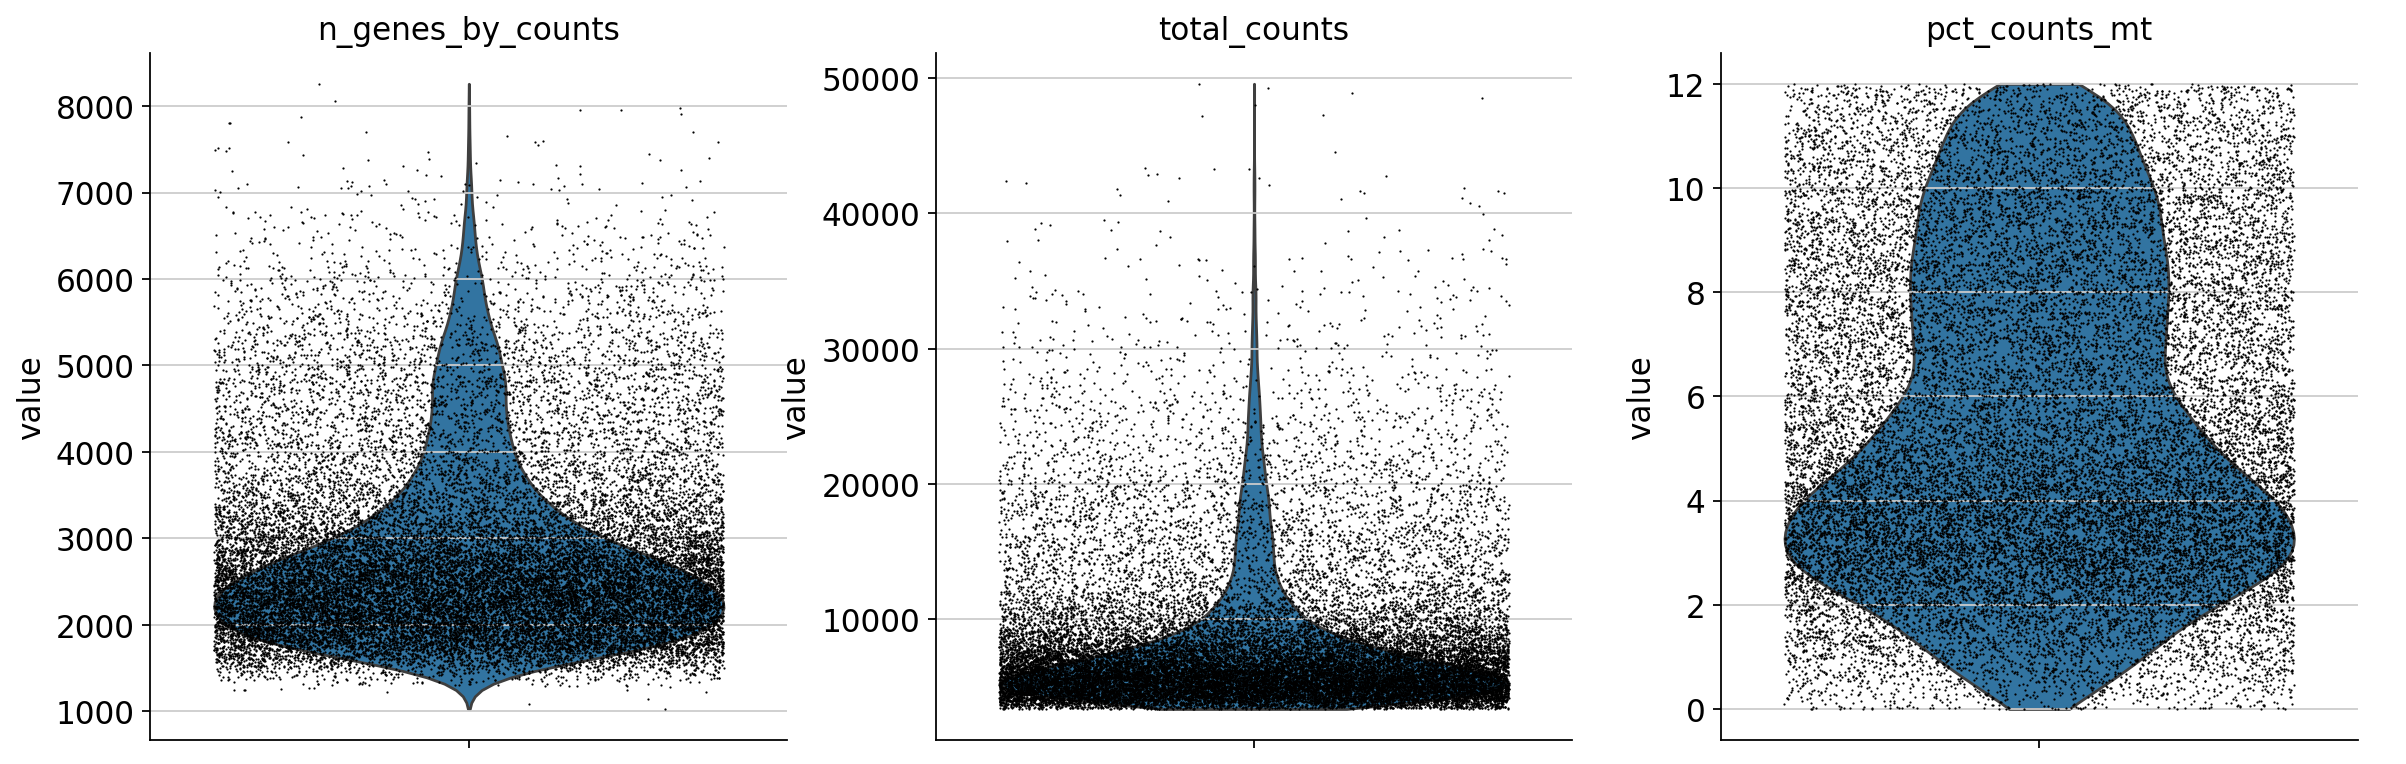

In [18]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

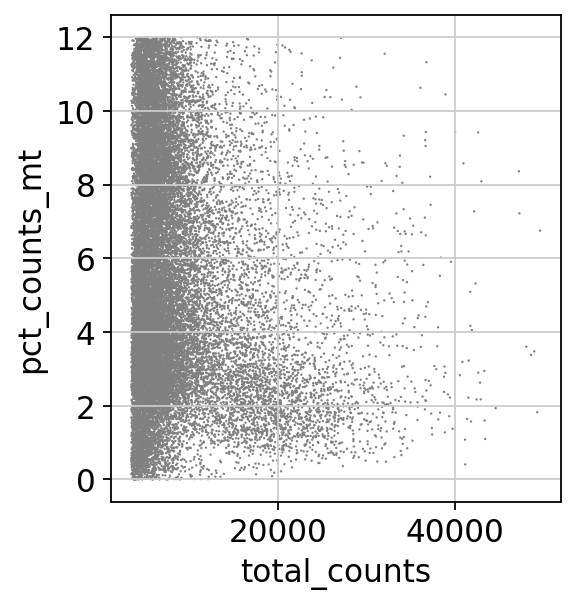

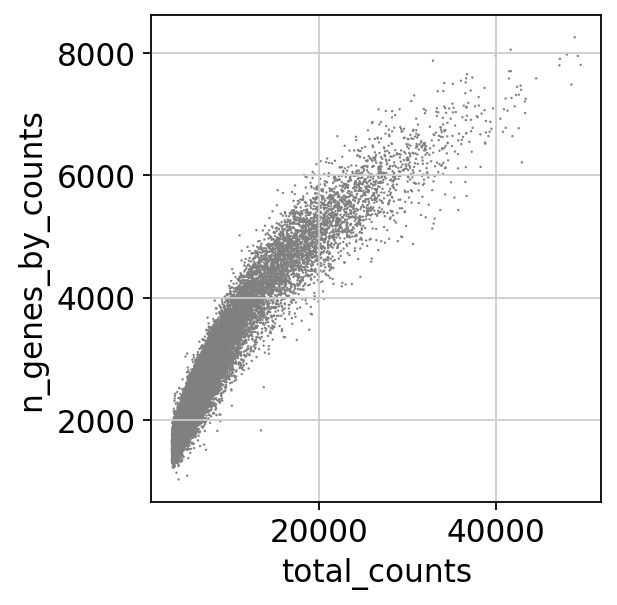

In [19]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

## Select the top 2000 most variable genes

In [20]:
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    subset=True,
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [37]:
# adata.write_h5ad("/data1/imoustakas/project-477-PGCLC_10x_yolanda/scvi/pgclc_mvg.h5ad")
adata = sc.read_h5ad("/data1/imoustakas/project-477-PGCLC_10x_yolanda/scvi/pgclc_mvg.h5ad")

In [38]:
scvi.model.SCVI.setup_anndata(adata)

In [39]:
model = scvi.model.SCVI(adata, 
                        n_layers=2, 
                        n_latent=20, 
                        gene_likelihood="zinb")

In [40]:
model.train()

/data1/imoustakas/miniforge3/envs/scvi/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data1/imoustakas/miniforge3/envs/scvi/lib/python3.9 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data1/imoustakas/miniforge3/envs/scvi/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data1/imoustakas/miniforge3/envs/scvi/lib/python3.9 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 303/303: 100%|██████████| 303/303 [07:38<00:00,  1.54s/it, v_num=1, train_loss_step=794, train_loss_epoch=753]

`Trainer.fit` stopped: `max_epochs=303` reached.


Epoch 303/303: 100%|██████████| 303/303 [07:38<00:00,  1.51s/it, v_num=1, train_loss_step=794, train_loss_epoch=753]


In [43]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [44]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata, 
             resolution=0.5)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:10)


In [45]:
SCVI_MDE_KEY = "X_scVI_MDE"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


/data1/imoustakas/miniforge3/envs/scvi/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data1/imoustakas/miniforge3/envs/scvi/lib/python3.9 ...


/data1/imoustakas/miniforge3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data1/imoustakas/miniforge3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data1/imoustakas/miniforge3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categoric

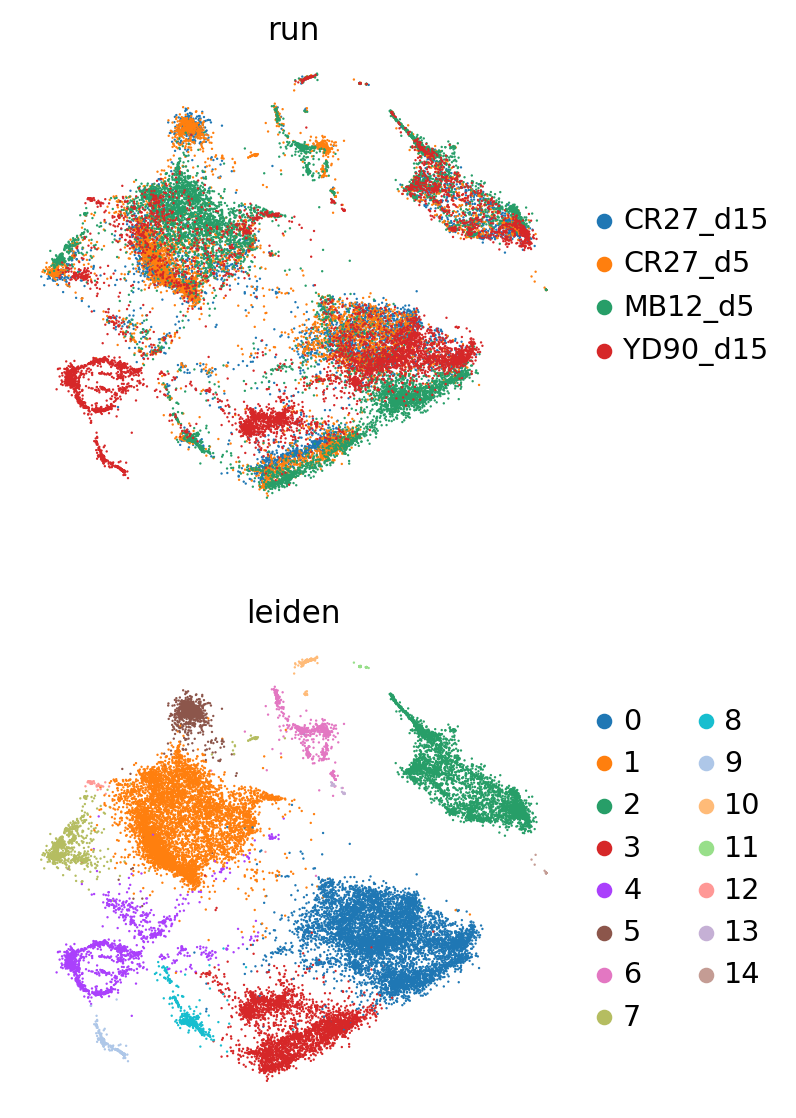

In [46]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=["run", "leiden"],
    frameon=False,
    ncols=1,
)

In [47]:
adata = adata.raw.to_adata()


### Normalization
The next preprocessing step is normalization. A common approach is count depth scaling with subsequent log plus one (log1p) transformation. Count depth scaling normalizes the data to a “size factor” such as the median count depth in the dataset, ten thousand (CP10k) or one million (CPM, counts per million). The size factor for count depth scaling can be controlled via target_sum in pp.normalize_total. We are applying median count depth normalization with log1p transformation (AKA log1PF).

In [48]:
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata, 
                      target_sum=50000)
# Logarithmize the data
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [49]:
adata.write_h5ad(filename="/data1/imoustakas/project-477-PGCLC_10x_yolanda/scvi/PGCLCs_scvi_layers_2_latent_20.h5ad")

In [32]:
! pwd

/home/imoustakas


/data1/imoustakas/miniforge3/envs/scvi/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
